In [1]:
import io, time, json, string, random
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import random
import pickle
import statsmodels.discrete.discrete_model as sm
from patsy import dmatrices
from wordcloud import WordCloud
from gender import GenderDetector

from easymoney.money import EasyPeasy
ep = EasyPeasy()

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

A Practical Data Science Final Project by Irina Javed and Siddharth Annldasula

# IMDb Data Analysis

## Introduction

Whether it be from the early days of black and white cinematography, to now the big budget blockbusters films, movies have been, and will continue to play, a significant part of modern day popular culture. Even though much has changed since the first films that were made in the 1890s, the recent successes of the "Superhero" movies and the emergance of the "Hollywood Gender Problem" has prompted us to analyze some trends in popular movies. This includes:

* What types (genres) of movies became popular over time?
* Are female directors and cast being more recognized in movies over time?

## Methods and Data

In order to look at analyze these trends, we webscraped the IMDb page for the top U.S. 100 grossing films every year from 1960 to 2018. (See Appendix for more on the parsing and scraping functions implemented).

Why 1960 as the starting point? Around the 1950s marked a great change in the modern film era. An increase in screen size, and the introduction of stereo sounds and color increased popularity of movies. These changes, eventually boosted sales, and the only major changes to movie industry were style and production.

Below we have what a couple of example rows from our web-scraped data looks like. (See appendix for function `parse_IMDb`).

In [2]:
# imdb_df = parse_IMDb()
# imdb_df.to_pickle('imdb.pkl')
imdb_df = pd.read_pickle('imdb.pkl')
imdb_df.head()

,Title,Year,MPAA,Runtime,Genre,IMDb,Metacritic,Summary,Directors,Cast,Votes,Gross
0,Swiss Family Robinson,1960,G,126.0,"[Adventure, Family]",7.2,NaN,A Swiss family must survive being shipwrecked ...,[Ken Annakin],"[John Mills, Dorothy McGuire, James MacArthur,...",11510.0,40356000.0
1,Psycho,1960,R,109.0,"[Horror, Mystery, Thriller]",8.5,97.0,"A Phoenix secretary embezzles $40,000 from her...",[Alfred Hitchcock],"[Anthony Perkins, Janet Leigh, Vera Miles, Joh...",495008.0,32000000.0
2,Spartacus,1960,PG-13,197.0,"[Adventure, Biography, Drama]",7.9,87.0,The slave Spartacus leads a violent revolt aga...,[Stanley Kubrick],"[Kirk Douglas, Laurence Olivier, Jean Simmons,...",108037.0,30000000.0
3,La Dolce Vita,1960,Not Rated,174.0,"[Comedy, Drama]",8.1,93.0,A series of stories following a week in the li...,[Federico Fellini],"[Marcello Mastroianni, Anita Ekberg, Anouk Aim...",55406.0,19516000.0
4,Exodus,1960,Approved,208.0,"[Action, Drama, History]",6.8,NaN,"The state of Israel is created in 1948, result...",[Otto Preminger],"[Paul Newman, Eva Marie Saint, Ralph Richardso...",7711.0,18966000.0


## Gross of Movies Over Time

Even though this was not a primary topic we wanted to discuss, we do use gross in some analysis later in the notebook, and thus felt it needed to be address. We just did some quick analysis of gross, including the mean and sum gross for the top 100 popular movies over time. Trivially, overall we do know that the movie industry makes more many each year, especially since the 1960s on just inflation alone. Thus, we wanted to analyze whether the overall gross of movies are is actually changing over time by adjusting the values for inflation. (See appendix for function `inflation_calculator`.)

Below, we calculate values for the actual and inflation-adjusted gross mean and sum, and plot their respective values.

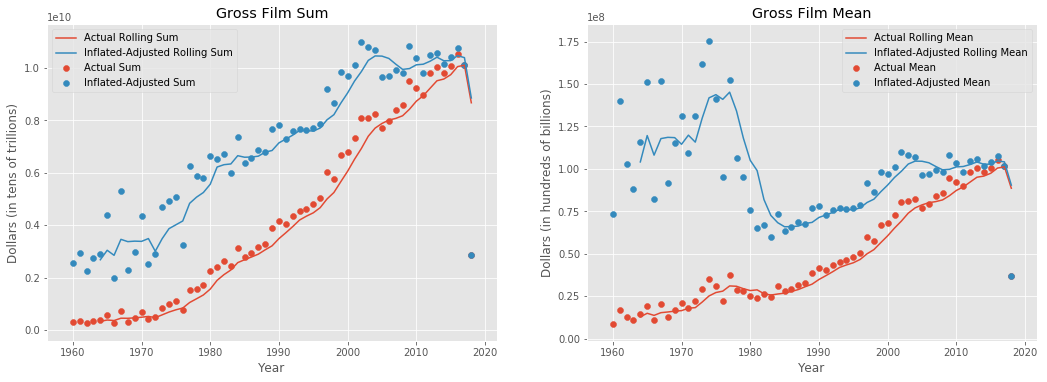

In [5]:
df_year = imdb_df.groupby(["Year"])
gross_mean = df_year["Gross"].mean()
gross_sum = df_year["Gross"].sum()
inflated_gross_mean = inflation_calculator(gross_mean)
inflated_gross_sum = inflation_calculator(gross_sum)

plt.subplot(1,2,1)
plt.plot(df_year.groups.keys(), df_year["Gross"].sum().rolling(5).mean(),label="Actual Rolling Sum")
plt.plot(df_year.groups.keys(), pd.DataFrame(inflated_gross_sum).rolling(5).mean(),label="Inflated-Adjusted Rolling Sum")
plt.scatter(df_year.groups.keys(),df_year["Gross"].sum(),label="Actual Sum")
plt.scatter(df_year.groups.keys(),inflated_gross_sum,label="Inflated-Adjusted Sum")
plt.xlabel("Year")
plt.ylabel("Dollars (in tens of trillions)")
plt.title("Gross Film Sum")
plt.legend()

plt.subplot(1,2,2)
plt.plot(df_year.groups.keys(), df_year["Gross"].mean().rolling(5).mean(),label="Actual Rolling Mean")
plt.plot(df_year.groups.keys(), pd.DataFrame(inflated_gross_mean).rolling(5).mean(),label="Inflated-Adjusted Rolling Mean")
plt.scatter(df_year.groups.keys(),df_year["Gross"].mean(),label="Actual Mean")
plt.scatter(df_year.groups.keys(),inflated_gross_mean,label="Inflated-Adjusted Mean")
plt.xlabel("Year")
plt.ylabel("Dollars (in hundreds of billions)")
plt.title("Gross Film Mean")
plt.legend()

plt.subplots_adjust(bottom = 0, right=1.5, hspace=0.3)

Above, we see that both the sum and mean overall is rising every year on the actual gross line, which is expected. However, one interesting finding that we see from the inflation-adjusted sum line is from the early 2000s,  the gross of movies has remained relatively constant overall. This is most intriguing, as it does possibly show a stunt in growth of the film industry in recent years, it does dispel popular beliefs that movies are on the decline due to competition from web-streaming services, such as Netflix and Amazon Video. 

One small thing that we seen in both graphs is the high variance in inflated-adjusted values from 1960 to about 1980. This can be attributed to a couple of movies during the time period that was pop cultural phenomenas (*Song of Music, Jaws, Star Wars, etc*), and also a good portion of movies did not have gross information. 

## Genre in Film

The rise of the *"Superhero"* decade has sparked our interest into what types of filmed was popular over time? Since there is no *"Superhero"* genre (darn), we hypothesize that there is an overall increase in genres that are similar, such as *action* and *adventure*. In order to address this question, we look at number of films, average IMDb score, and the gross for each genre of film.

Below, we create our data structure to look at genre in films, and an example of a couple of rows for movies that are part of the genre *drama*.

In [6]:
all_genres = dict()
for index,rows in imdb_df.iterrows():
    genres = rows["Genre"]
    for genre in genres:
        g = genre.strip()
        if g not in all_genres: all_genres[g] = [rows]
        else: all_genres[g].append(rows)         
for g in all_genres:
    all_genres[g] = pd.DataFrame(np.array(all_genres[g]), columns = imdb_df.columns.values) 

all_genres["Drama"].head(5)

,Title,Year,MPAA,Runtime,Genre,IMDb,Metacritic,Summary,Directors,Cast,Votes,Gross
0,Spartacus,1960,PG-13,197,"[Adventure, Biography, Drama]",7.9,87,The slave Spartacus leads a violent revolt aga...,[Stanley Kubrick],"[Kirk Douglas, Laurence Olivier, Jean Simmons,...",108037,3e+07
1,La Dolce Vita,1960,Not Rated,174,"[Comedy, Drama]",8.1,93,A series of stories following a week in the li...,[Federico Fellini],"[Marcello Mastroianni, Anita Ekberg, Anouk Aim...",55406,1.9516e+07
2,Exodus,1960,Approved,208,"[Action, Drama, History]",6.8,NaN,"The state of Israel is created in 1948, result...",[Otto Preminger],"[Paul Newman, Eva Marie Saint, Ralph Richardso...",7711,1.8966e+07
3,The Apartment,1960,Not Rated,125,"[Comedy, Drama, Romance]",8.3,NaN,A man tries to rise in his company by letting ...,[Billy Wilder],"[Jack Lemmon, Shirley MacLaine, Fred MacMurray...",132023,1.86e+07
4,The Alamo,1960,Not Rated,162,"[Adventure, Drama, History]",6.9,NaN,"In 1836, a small band of soldiers sacrifice th...",[John Wayne],"[John Wayne, Richard Widmark, Laurence Harvey,...",12199,1.72629e+07


### Movies Made Per Year 

We first looked at the number of the movies made per year in genre. The first plot shows all genre movies and the count of such movies every year. As we see, the plot is extremly messy, and thus we only look at a select subset of genres which are interesting. This includes *Drama, Action, Adventure, Comedy, Crime, Sci-Fi,* and *History*.

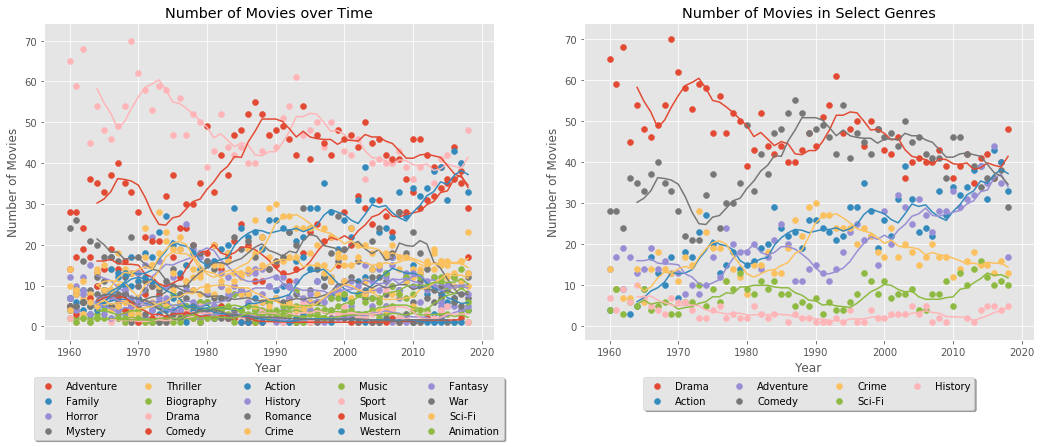

In [7]:
ax = plt.subplot(121)
for g in all_genres:
    b = all_genres[g].groupby(["Year"])
    r = pd.DataFrame(b.size())
    plt.plot(list(b.groups.keys()), r.rolling(5).mean())
    plt.scatter(list(b.groups.keys()),r, label=g)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  shadow=True, ncol=5)
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.title("Number of Movies over Time")

ax = plt.subplot(122)
for g in ["Drama","Action","Adventure","Comedy","Crime","Sci-Fi","History"]:
    b = all_genres[g].groupby(["Year"])
    r = pd.DataFrame(b.size())
    plt.plot(list(b.groups.keys()), r.rolling(5).mean())
    plt.scatter(list(b.groups.keys()),r, label=g)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  shadow=True, ncol=4)
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.title("Number of Movies in Select Genres")
plt.subplots_adjust(bottom = 0, right=1.5, hspace=0.3)

We see on the above right that for the latter part of the 20th century, both Drama and Comedy dominated the film industry. Actually, the sheer dominance of *drama* films from 1960 to 1980 is staggering, before more popular *comedy* films were being made and the both were juking it for a long time. However, for the past 20 years, both *action* and *adventure* movies are on the rise and have caught up with the front runners. This shows a shift in the taste of moviegoers as people are looking for more exciting and intense movies. *Crime* movies are also pretty interesting because they enjoyed a nice rise around the year 1990, but have been on the decline ever since. 

### Gross Per Select Genres

Next, we looked at the sum gross per genre over time with and without inflation-adjusted.

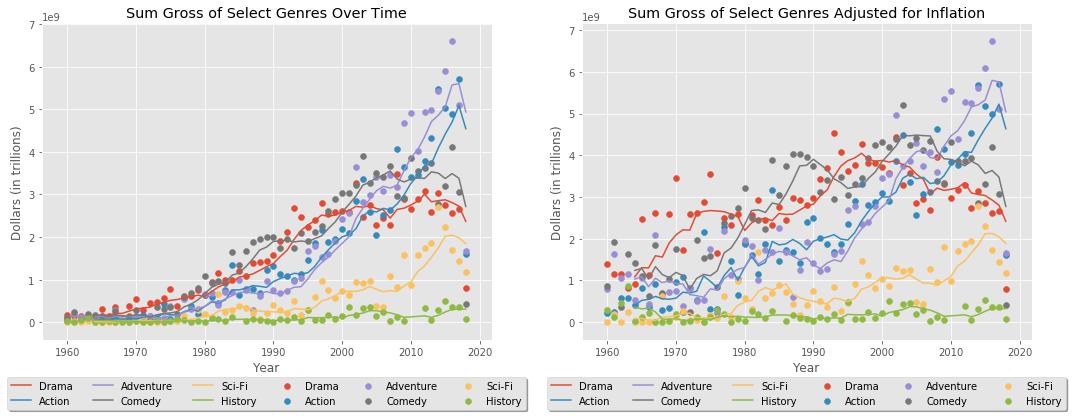

In [8]:
ax = plt.subplot(121)
for g in ["Drama","Action","Adventure","Comedy","Sci-Fi","History"]:
    a = all_genres[g].groupby(["Year"])
    r = a["Gross"].apply(list).apply(np.nansum)
    plt.plot(list(a.groups.keys()), r.rolling(5).mean(),label=g)
    plt.scatter(list(a.groups.keys()),r, label=g)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  shadow=True, ncol=6)
plt.xlabel("Year")
plt.ylabel("Dollars (in trillions)")
plt.title("Sum Gross of Select Genres Over Time")

ax = plt.subplot(122)
for g in ["Drama","Action","Adventure","Comedy","Sci-Fi","History"]:
    a = all_genres[g].groupby(["Year"])
    r = inflation_calculator(a["Gross"].apply(list).apply(np.nansum))
    plt.plot(list(a.groups.keys()), r.rolling(5).mean(),label=g)
    plt.scatter(list(a.groups.keys()),r, label=g)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  shadow=True, ncol=6)
plt.xlabel("Year")
plt.ylabel("Dollars (in trillions)")
plt.title("Sum Gross of Select Genres Adjusted for Inflation")
plt.subplots_adjust(bottom = 0, right=1.5, hspace=0.3)

Similar to what see in the first section on gross, we see an overall increase in the gross of all genres (outside for the dip for 2018). Also, similar to what we see directly above, *action* and *adventure* have outperformed and almost doubled the gross for *drama* and *comedy* movies (even though the number of movies being made are similar). So much so that that it has increased six-fold from ~1995. We see similar results when adjust for inflation. However, the trend that is of significance is that the gross for *comedy* and *drama* movies has been on the decline since 2000. This can be attributed to the overall decrease in the popularity these types of movies.

### Mean IMDb Score per Genre

Lastly, we looked at the mean IMDb score per genree over time to see if these popular genres were good and well received by moviegoers.

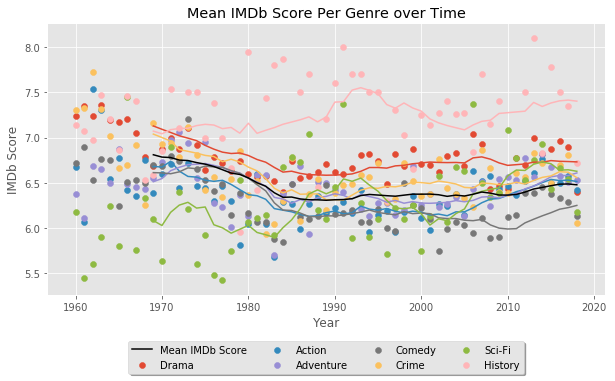

In [9]:
ax = plt.subplot(111)
for g in ["Drama","Action","Adventure","Comedy","Crime","Sci-Fi","History"]:
    a = all_genres[g].groupby(["Year"])
    b = a["IMDb"].apply(list)
    r = pd.DataFrame(b.apply(np.nanmean))
    plt.plot(list(a.groups.keys()), r.rolling(10).mean())
    plt.scatter(list(a.groups.keys()),b.apply(np.nanmean), label=g)
plt.plot(df_year.groups.keys(), df_year["IMDb"].mean().rolling(10).mean(),color="Black",label="Mean IMDb Score")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),  shadow=True, ncol=4)
plt.xlabel("Year")
plt.ylabel("IMDb Score")
plt.title("Mean IMDb Score Per Genre over Time")
plt.show()

Most genres had a constant IMDb score on a yearly basis. However, the *history* genre, in pink, performs much better than the other genres, by constantly a half to one point better. Looking at the first graph, we see that there are not many popular history movies per year. These results suggests that the popular history movies have better quality overall. Another interesting finding is that *comedy* movies, though popular, have been not well received. Finally, looking at the genres that currently popular genres (*action* and *adventure*), they are not that well received compared to *drama*, citing that even though the quality of *drama films* is be better, moviegoers still prefer the new era genres.

## Exploring Film and Gender

### Women in Directing
How we view stories often depends on who tells them. Historically, it is often men who have taken on this role as director of our stories. That we as audiences view stories from the viewpoint of only half the human populace, is disconcerting to say the least. Hollywood wants us to believe that it is getting better, and it seemingly is. Ava Duvernay, Greta Gerwig, Patty Jenkins, Dee Rees, are just some names we have heard directing major films this year. But major names does not necessarily translate to equal representation. Furthermore, it is important to look at how many female directors there are in the top grossing films. These top films are often big studio ventures, and if more women are directing big studio films, it means that studios are trusting women more and more to tell stories. 

Thus we look at trends in women directing films in the top 100 grossing films per year, to see if there is actually an increase. For every top film from 1960 to now, we determine if there was a female director at the helm. We also looked at the principal cast (the top four billed actors/actresses in the film) and labeled them as male or female. We will explore that further in a later section.

We add this information by adding two new columns, labeled `Directors_gender` and `Cast_gender`.

In [10]:
gd = GenderDetector()
def get_gen(l):
    if l == None or len(l) == 0:
        return []
    else:
        gen = [gd.gender(i.split(" ")[0]) for i in l[0].split(", ")]
        return gen

## This is commented out because it takes a long time!! ##
# gender_df = imdb_df.copy()
# start = time.time()
# gender_df['Directors_gender'] = gender_df['Directors'].apply(get_gen)
# gender_df['Cast_gender'] = gender_df['Cast'].apply(get_gen)
# end = time.time()
# print(start-end)

# gender_df.to_pickle('gender_df.pkl')
gender_df = pd.read_pickle('gender_df.pkl')
gender_df.head()

,Title,Year,MPAA,Runtime,Genre,IMDb,Metacritic,Summary,Directors,Cast,Votes,Gross,Directors_gender,Cast_gender
0,Swiss Family Robinson,1960,G,126.0,"[Adventure, Family]",7.2,NaN,A Swiss family must survive being shipwrecked ...,[Ken Annakin],"[John Mills, Dorothy McGuire, James MacArthur,...",11511.0,40356000.0,[m],"[m, f, m, m]"
1,Psycho,1960,R,109.0,"[Horror, Mystery, Thriller]",8.5,97.0,"A Phoenix secretary embezzles $40,000 from her...",[Alfred Hitchcock],"[Anthony Perkins, Janet Leigh, Vera Miles, Joh...",495259.0,32000000.0,[m],"[m, f, m, m]"
2,Spartacus,1960,PG-13,197.0,"[Adventure, Biography, Drama]",7.9,87.0,The slave Spartacus leads a violent revolt aga...,[Stanley Kubrick],"[Kirk Douglas, Laurence Olivier, Jean Simmons,...",108064.0,30000000.0,[m],"[m, m, m, m]"
3,La Dolce Vita,1960,Not Rated,174.0,"[Comedy, Drama]",8.1,93.0,A series of stories following a week in the li...,[Federico Fellini],"[Marcello Mastroianni, Anita Ekberg, Anouk Aim...",55429.0,19516000.0,[m],"[m, f, f, f]"
4,Exodus,1960,Approved,208.0,"[Action, Drama, History]",6.8,NaN,"The state of Israel is created in 1948, result...",[Otto Preminger],"[Paul Newman, Eva Marie Saint, Ralph Richardso...",7713.0,18966000.0,[m],"[m, m, m, m]"


#### Number of Directors per Year by Gender
We first look at the total number of female and male directors per year, shown in the bar charts below. We can see that the number of male/female directors don't seem to vary greatly by year, and the number of female directors show little sign of upwards trend.

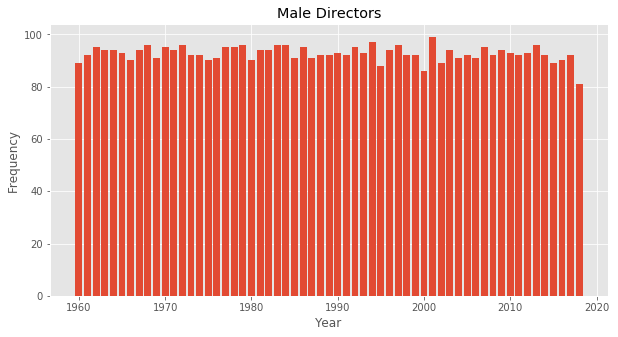

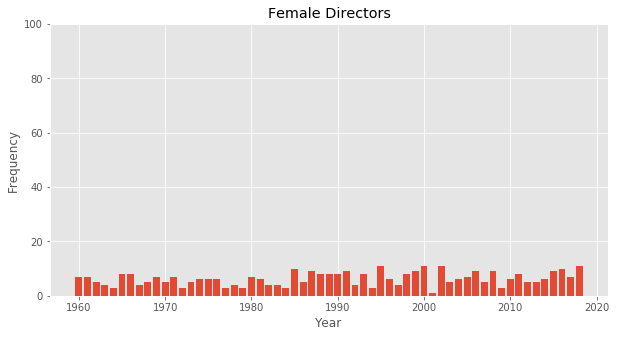

In [11]:
gender_df['director_f'] = gender_df['Directors_gender'].apply(lambda x: float('f' in x))
gender_df['director_m'] = gender_df['Directors_gender'].apply(lambda x: float('m' in x))

plt.bar(gender_df['Year'].unique(), 
        gender_df.groupby('Year')['director_m'].sum())
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title("Male Directors")
plt.show()
plt.bar(gender_df['Year'].unique(), 
        gender_df.groupby('Year')['director_f'].sum())
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title("Female Directors")
plt.ylim(0,100)
plt.show()

#### Proportion of Female Directors
We took a closer look at the female directors by looking at the proportion of female directors over the years to see if we couldn't find a clear trend.

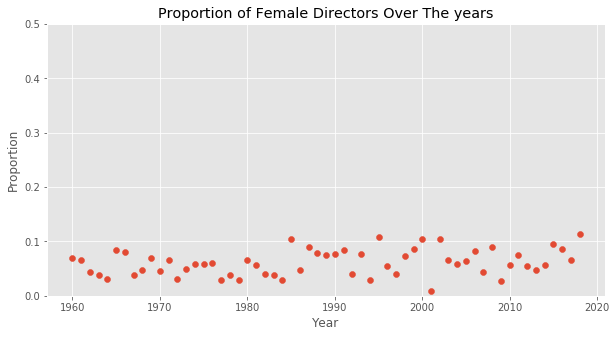

In [12]:
def return_gender_prop(df, col):
    directors_gen = df.groupby('Year')[col].apply(list)
    def gender_prop(l):
        f_l = np.array([item for sublist in l for item in sublist])
        fem_prop = (f_l == 'f').sum() / (f_l != None).sum()
        return fem_prop
    gender_prop = directors_gen.apply(gender_prop)
    return gender_prop

all_dir_gen = return_gender_prop(gender_df, 'Directors_gender')

plt.scatter(all_dir_gen.index, all_dir_gen)
#plt.plot(all_dir_gen.index, all_dir_gen.rolling(10).mean(), c="red", linewidth=0.5)
plt.ylim(0,0.5)
plt.xlabel("Year")
plt.ylabel("Proportion")
plt.title("Proportion of Female Directors Over The years")
plt.show()

We see that the proportion of female directors in the top 100 grossing films per year remained between 0 and 0.1, with a small bump around the 2000s. This unsurprisingly support what we viewed in the bar charts from above.
##### Breaking it Down by Genre
We break down these trends by genre, to see where our values are coming from. Movies can be classified under a number of genres, so movies can contribute to multiple trends. We chose 4 genres below to demonstrate the differences

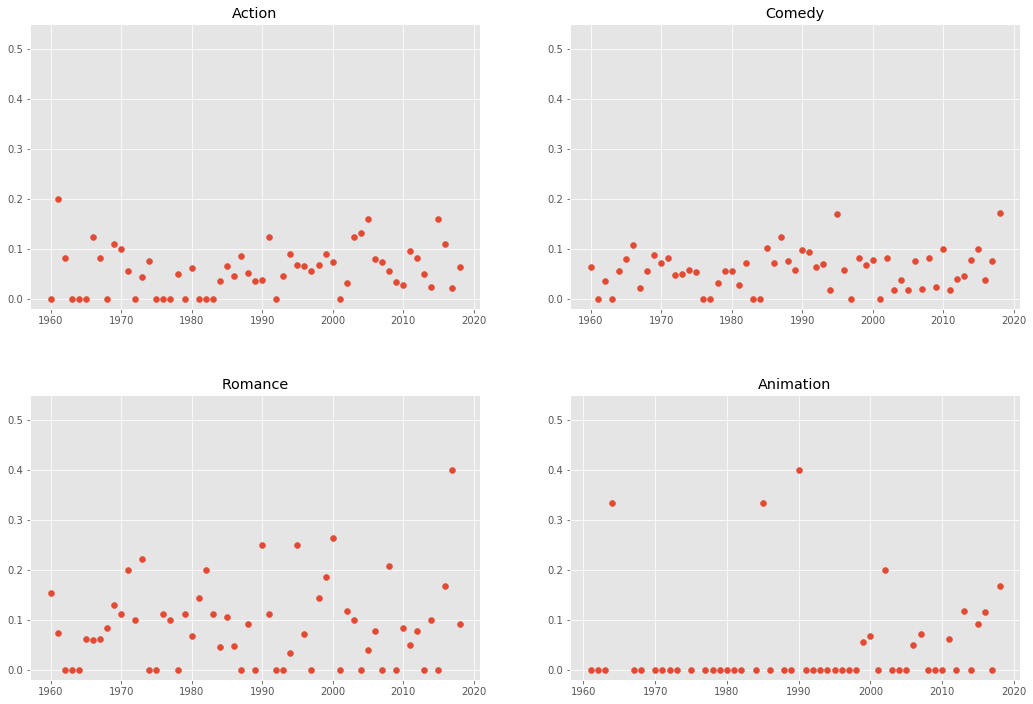

In [13]:
all_genres = np.unique([g for l in gender_df['Genre'] for g in l])

for i, genre in enumerate(['Action', 'Comedy', 'Romance', 'Animation']):
    genre_df = return_gender_prop(gender_df[gender_df["Genre"].apply(lambda x: genre in x)], "Directors_gender")
    plt.subplot(4,2,i+1)
    plt.scatter(genre_df.index, genre_df)
    plt.ylim(-0.02,0.55)
    plt.title(genre)
plt.subplots_adjust(bottom = -3, right=1.5, hspace=0.3)
#  6, 17, 18

Actions movies have very low proportions of female directors, and more often than not from 1960 to 1984, the proportion was zero. Comedy similarly has very low proportions, but women have been present in some capacity since 1960. Romance, out of all of the genres, had the highest proportions of female directors. But even then, the higest proportion only came out to be 0.4 and was in 2017. Animation was interesting in that women only seemed to enter the field in the late 90s onwards. This may be due to a larger amount of animated films being made, but it still shows how much of a boy's club animation was for suhc a long time.

#### Proportion of Women in the Principal Cast
Just as who is behind the camera is guiding the story, who is actually present on the screen tells us something about the kinds of stories being told. Women make up half of the human population, so intuition should tell us that they should make up half of the stories that we tell. So we study at the proportion of women on screen for each year by looking at the principal cast (the top four billed actors/actresses).

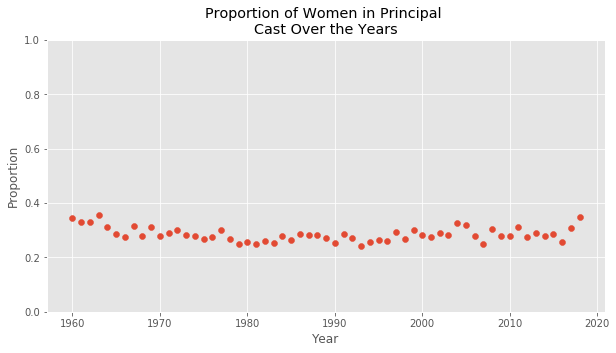

In [14]:
all_cast_gen = return_gender_prop(gender_df, 'Cast_gender')

plt.scatter(all_cast_gen.index, all_cast_gen)
# plt.plot(all_cast_gen.index, all_cast_gen.rolling(10).mean(), c="red", linewidth=0.5)
plt.ylim(0,1)
plt.xlabel("Year")
plt.ylabel("Proportion")
plt.title("Proportion of Women in Principal \nCast Over the Years")
plt.show()

Judging from this graph, the proportion of women in the principal cast in the top 100 grossing films remains fairly constant just under 0.4. 
##### Breaking it down by Genre
We chose Drama, Horror, Romance, and War films to take a closer look at trends by genre.

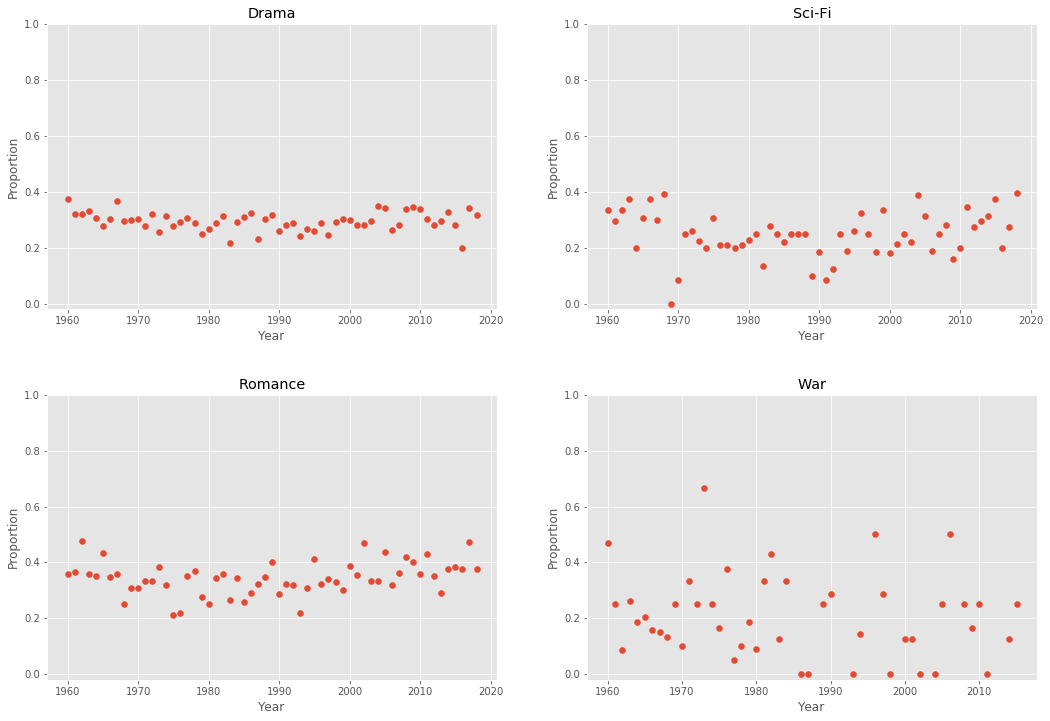

In [15]:
for i, genre in enumerate(['Drama', 'Sci-Fi', 'Romance', "War"]):
    genre_df = return_gender_prop(gender_df[gender_df["Genre"].apply(lambda x: genre in x)], "Cast_gender")
    plt.subplot(4,2,i+1)
    plt.scatter(genre_df.index, genre_df)
    plt.ylim(-0.02,1)
    plt.title(genre)
    plt.xlabel("Year")
    plt.ylabel("Proportion")
plt.subplots_adjust(bottom = -3, right=1.5, hspace=0.3)

Drama films out of any other genre remained the most constant around 0.4 and had the least variation. Sci-Fi constained a lot more variation in the earlier years, possibly due to a smaller amount of Sci-Fi films being made at the time, but then the proportion of women became settled around being under 0.4. Romance had the highest proportion of women, centered around 0.5. This makes sense, given that Hollywood romances are often between heterosexual couples and those couple need women! And finally war films contained the highest variation of women in the principal cast, and we can even see that there were 6 years in which zero women made up the principal cast in any of the war movies. 

## Final and Future Thoughts

In our genre analysis, we do see a shift in the taste of current moviegoers with *adventure* and *action* movies are increasingly  popular and gross more than *old school movies*, such as *drama* and *comedy*. However, these new-era genres are not well received compared with *drama* films, citing the possible influence of the film's overall experiance rather than the quality is what attracts current age moviegoers.

What we found in our gender analysis is that Hollywood has a long way to go. No clear strides have been made, and it seem that popular female director names like the ones I listed before to not translate in a higher proportion of women make movies in the top 100. Furthermore, there seems to be be too much variation, and more than that variation around a mean of below 0.5, when it comes to the proportion of women in the principal cast of a film.

Some further areas of investigation can be to expand our constraint of looking at just the top 100 grossing movies per year. Even though this is realistic in terms of the cultural impact of movies, this does not give a broad sense of what is happening in the film industry. We can also expand our methodology to not just U.S. movies, but to international films. Thus, we would be able to analyze global trends for our questions as well. For genre specifically, we can look more about what combination of genres have been popular. For the gender analysis, we can can implement a gender learning function ourselves. Even though the one that we use is adequate, it can still be improved upon, especially by using machine learning strategies for example.

### Word Clouds
We thought it would be cool to compile the summaries the all of the films we looked at by genre, and create wordclouds from them. Below are some interesting ones.

And with a last thought...a common word found across many of the genres is the word "find". Which is nice, because at the end of the day, can't all of the stories we choose to tell be distilled into a search for something?

Crime


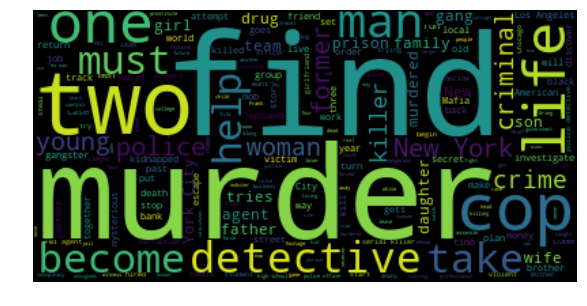

Romance


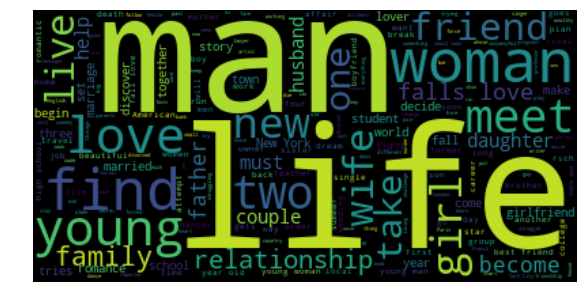

Western


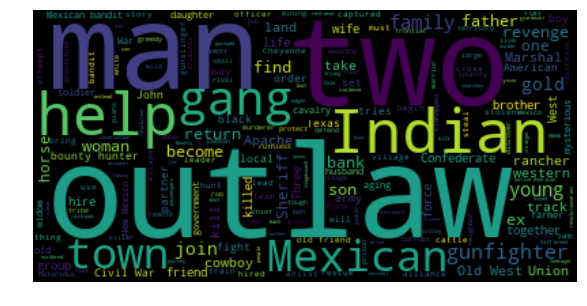

War


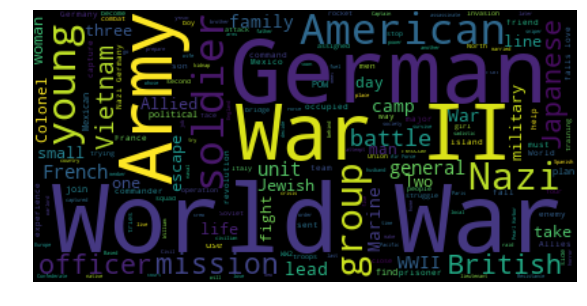

In [16]:
def get_rid(sent):
    pattern = "See full summary"
    pos = re.search(pattern, sent)
    if pos != None:
        return sent[:pos.start()]
    else:
        return sent
        
imdb_df['Summary'] = imdb_df['Summary'].apply(get_rid)

for genre in ['Crime','Romance','Western','War']: 
    genre_df = imdb_df[imdb_df["Genre"].apply(lambda x: genre in x)]
    
    text = " ".join(genre_df['Summary'].tolist())
    wordcloud = WordCloud().generate(text)
    print(genre)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## Appendix

### Webscraping Code

Below are the functions that we used to web-scrape the IMDb pages. Especially when scraping the older movies, there was a lot of cases where there was no data available, and thus needed to account for that.

In [3]:
# Return the raw HTML of input URL
def retrieve_html(url):
    response = requests.get(url)
    return response.content

# Parse the movies from a single page from IMDb given the html and the year
def parse_page(html,year):
    col_names = ["Title", "Year","MPAA","Runtime","Genre","IMDb","Metacritic","Summary","Directors","Cast","Votes","Gross"]
    page = []
    root = BeautifulSoup(html, 'html.parser')
    movie_list = root.find_all("div", class_="lister-list")[0]
    for movie in movie_list.find_all("div", class_="lister-item mode-advanced"):
        movie_info = movie.find("div", class_="lister-item-content")
    
        title = movie_info.find("a").text
        try: mpaa = movie.find("span",class_="certificate").text
        except: mpaa = None
        
        try: runtime = movie.find("span",class_="runtime").text.split(" ")[0]
        except: runtime = None
        
        try: genre = movie.find("span", class_="genre").text.strip().split(", ")
        except: None
        
        ratings_bar = movie.find("div",class_ = "ratings-bar")
        try: imdb = float(ratings_bar.find("div", class_ = "inline-block ratings-imdb-rating").get("data-value"))
        except: imdb = None
        
        try: metascore = int(ratings_bar.find("div", class_ = "inline-block ratings-metascore").text[1:3].strip())
        except: metascore = None
                    
        summary = movie.find_all("p")[1].text.strip()
        
        cast = movie.find_all("p")[2].text.strip()
        cast = cast.replace("\n", "")
        try: director = cast.split("|")[0].split(":")[1:]
        except: director = None
        try: stars = cast.split("|")[1].split(":")[1:]
        except: stars = None
        
        popularity = movie.find("p", class_ = "sort-num_votes-visible").find_all("span")
        try: votes = int(popularity[1].text.replace(",",""))
        except: votes = None
        try: gross = popularity[4].get("data-value").replace(",","")
        except: gross = None
            
        page.append([title,year,mpaa,runtime,genre,imdb,metascore,summary,director,stars,votes,gross])
    
    pdf = pd.DataFrame(np.array(page, dtype = object),columns=col_names)
    pdf = pdf.apply(pd.to_numeric, errors='ignore')
    return pdf

def parse_IMDb():
    imdb_df = pd.DataFrame()
    for year in range(1960,2019):
        page_url = ('https://www.imdb.com/search/title?title_type=feature&release_date={}-01-01,'.format(year) + 
                                                '{}-12-31&sort=boxoffice_gross_us,desc&count=100'.format(year))
        if year == 2018:
            page_url = ('https://www.imdb.com/search/title?title_type=feature&release_date={}-01-01,'.format(year) + 
                                                '{}-4-29&sort=boxoffice_gross_us,desc&count=100'.format(year))
        print(year)
        page_data = parse_page(retrieve_html(page_url), year)
        imdb_df = imdb_df.append(page_data, ignore_index=True)
        time.sleep(random.randint(1,3)) # To not get blocked shhhhhhh...
    return imdb_df

### Adjusted-Inflation Calculator

Below is the code to calculate the adjusted inflation value. Values were adjusted to the current standing of the US dollar.

In [4]:
# Given a pd.series, calculates the adjusted inflation values
def inflation_calculator(series):
    start_year = 1960
    for i in range(len(series)):
        year = start_year + i
        gross = series.iloc[i]
        if (i == len(series) - 1): inflated = gross
        else:
            inflated = ep.normalize(amount=gross, region="United States", from_year=year, to_year="latest", base_currency="USD")
        series.iloc[i] = inflated
    return series

# Fin.